In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from copy import deepcopy
from delase import DeLASE
from delase.metrics import mase
from hydra import compose, initialize
from matplotlib import font_manager
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import socket
import sys
from tqdm.auto import tqdm

sys.path.append('..')
from data_utils import get_delase_results, get_delase_run_list, get_grid_search_results, get_grid_search_run_list, get_grid_search_window_ts, get_section_info, load_session_data, load_window_from_chunks

plt.style.use('../sci_style.mplstyle')
hostname = socket.gethostname()
if 'endeavour' in hostname:
    font_path = "/usr/share/fonts/TTF/Arial.TTF"
else:
    font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

In [4]:
with initialize(version_base="1.3", config_path="../DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [88]:
# session = "PEDRI_Ketamine_20220222"
session = "SPOCK_Ketamine_20210715"

In [89]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, ['sessionInfo', 'electrodeInfo', 'lfp'], data_class=cfg.params.data_class)
session_info, electrode_info, lfp = session_vars['sessionInfo'], session_vars['electrodeInfo'], session_vars['lfp']

Loading data: ['sessionInfo', 'electrodeInfo', 'lfp', 'lfpSchema']...
sessionInfo : dict with keys[Properties,date,dose,drug,expType,infusionEnd,infusionStart,numCorrect,numTrials,pctCorrect,session,subject,tasks,]

electrodeInfo : dict with keys[Properties,area,array,channel,chnlID,electrode,file,gridLoc,hasLFP,hemisphere,numUnits,session,]

lfp : numpy.array(21141618,128,) of type float64

lfpSchema : dict with keys[dataDim,dataUnits,description,dims,history,index,indexUnits,mask,smpInterval,smpRate,timeUnits,userData,]

Data loaded (took 114.88 seconds)


# Find Bad Electrodes

In [90]:
amplitude_thresh = 1
# window_flag_thresh = N/10
window_flag_thresh = 10

In [91]:
window = 15
window_starts = np.arange(0, T*dt - window, window)
window_df = []
for i, window_start in tqdm(enumerate(window_starts), total=len(window_starts)):
    window_end = window_start + window
    window_data = lfp[int(window_start/dt):int((window_end)/dt)]
    max_vals = (np.abs(window_data)).max(axis=0)
    bad_electrodes = np.where(max_vals > amplitude_thresh)[0]
    window_df.append(dict(
        window_start=window_start,
        window_end=window_end,
        max_vals=max_vals,
        bad_electrodes=bad_electrodes,
        num_bad_electrodes=len(bad_electrodes)
    ))
    # if window_start == 750:
    #     print(max_vals)
    #     break
window_df = pd.DataFrame(window_df)

  0%|          | 0/1409 [00:00<?, ?it/s]

In [92]:
electrode_quality_img = np.zeros((N, len(window_df)))
for i, window_row in window_df.iterrows():
    electrode_quality_img[window_row.bad_electrodes, i] = 1

In [93]:
np.unique(electrode_quality_img)

array([0., 1.])

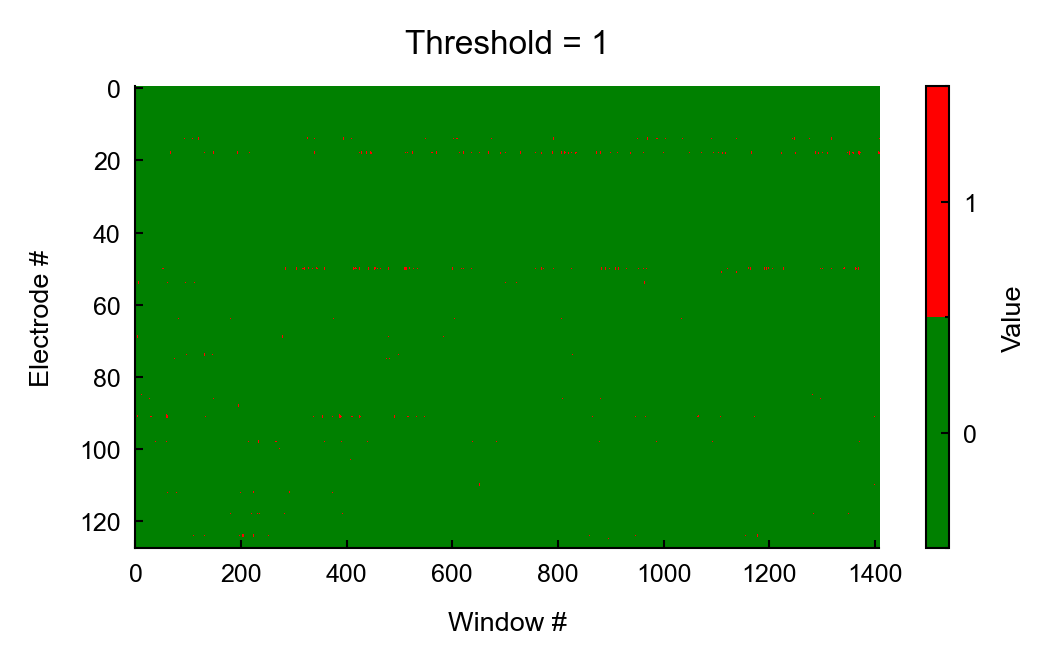

In [94]:
# Create a color map
cmap = plt.cm.colors.ListedColormap(['green', 'red'])

# Create bounds for the color map
bounds = [-0.5, 0.5, 1.5]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

# Create the plot
plt.figure(figsize=(4, 2))
plt.imshow(electrode_quality_img, cmap=cmap, norm=norm, aspect='auto')

# Add a color bar
plt.colorbar(ticks=[0, 1], label='Value')

# Set title and labels
plt.title('Threshold = {}'.format(amplitude_thresh))
plt.xlabel('Window #')
plt.ylabel('Electrode #')

# Show the plot
plt.show()

In [95]:
np.sum(electrode_quality_img.sum(axis=0) == 0)/len(window_df)

np.float64(0.5947480482611781)

In [96]:
electrode_quality_img.sum(axis=1).argsort()[::-1]

array([ 18,  50,  91,  14,  98, 124,  64, 118, 112,  54,  75,  74,  86,
        51, 110,  69,  79,  20,  85, 103,  88,  12, 125, 100,  37, 113,
       115, 114, 107, 111, 109, 116,  96,  97,  99, 101, 102, 106, 105,
       104, 108,  89,  87,  90,  92,  93,  95,  94,  80,  81,  82,  83,
        84,  77,  76,  78, 120, 121, 117, 119, 123, 122, 126, 127,  65,
        66,  67,  68,  71,  70,  73,  72,  56,  57,  58,  55,  59,  62,
        61,  63,  48,  47,  45,  46,  43,  42,  41,  44,  40,  39,  38,
        36,  52,  53,  49,  60,  32,  33,  34,  35,  27,  26,  31,  30,
        24,  25,  22,  23,  21,  19,  29,  28,  16,  17,  15,  13,  11,
        10,   9,   8,   7,   6,   5,   4,   3,   2,   1,   0])

In [109]:
2165*100

216500

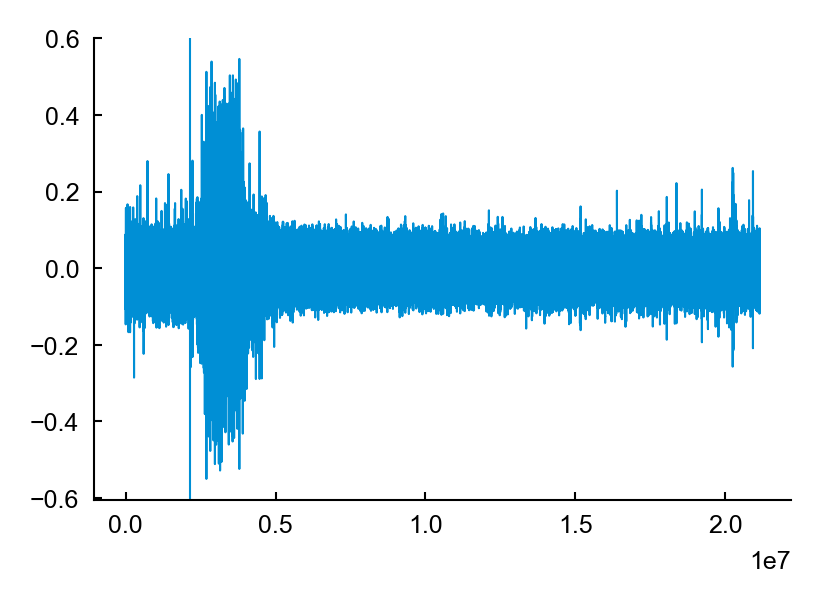

In [110]:
plt.plot(lfp[:, 39])
# plt.xlim([0.4e7, 0.408e7])
# plt.ylim([-0.25, 0.25])
plt.axvline(session_info['infusionStart']*1000)
plt.show()

In [98]:
np.where(electrode_quality_img.sum(axis=0) == 1)[0]

array([   3,    6,   12,   18,   20,   26,   27,   29,   30,   31,   34,
         35,   38,   41,   47,   49,   53,   54,   60,   64,   66,   67,
         74,   78,   82,   83,   87,   92,   93,   95,   96,   97,   98,
        100,  104,  105,  107,  108,  110,  111,  112,  115,  120,  122,
        125,  130,  133,  145,  146,  147,  157,  159,  164,  171,  174,
        177,  178,  179,  187,  188,  191,  192,  193,  195,  197,  199,
        202,  203,  204,  205,  209,  213,  214,  220,  221,  225,  228,
        231,  233,  235,  244,  252,  253,  255,  259,  262,  263,  265,
        267,  272,  273,  277,  282,  284,  292,  293,  295,  297,  298,
        304,  305,  308,  310,  318,  319,  320,  323,  326,  328,  329,
        335,  337,  343,  349,  353,  354,  357,  368,  374,  375,  376,
        381,  383,  385,  387,  388,  391,  392,  394,  395,  397,  398,
        399,  401,  406,  407,  410,  411,  412,  413,  415,  416,  417,
        418,  419,  420,  421,  425,  426,  428,  4

In [99]:
row = window_df.iloc[1]

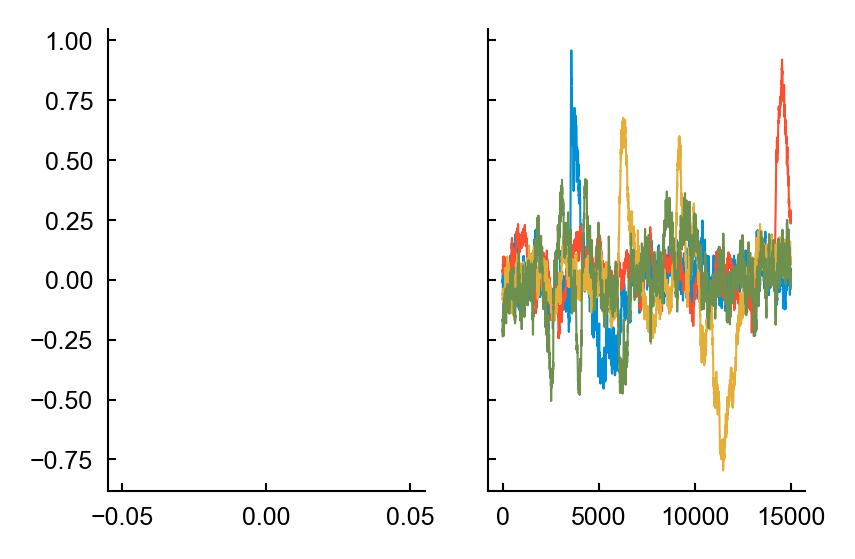

In [100]:
fig, axs = plt.subplots(1, 2, sharey=True)
window_data = lfp[int(row.window_start/dt):int((row.window_end)/dt)]

bad_electrode_inds = np.argsort(row.max_vals)[::-1][:row.num_bad_electrodes]
good_electrode_inds = np.argsort(row.max_vals)[::-1][row.num_bad_electrodes:]

ax = axs[0]
ax.plot(window_data[:, bad_electrode_inds])

ax = axs[1]
ax.plot(window_data[:, good_electrode_inds[:4]])

plt.show()

# Windows with Noise Disturbance

In [101]:
noisy_windows = window_df[window_df.num_bad_electrodes >= window_flag_thresh]

In [102]:

ncols = 5
nrows = int(np.ceil(len(noisy_windows) / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3), sharex=False, sharey=False)

num_electrodes_to_plot = 5

noisy_window_data = []
window_num = 0
for i, row in tqdm(noisy_windows.iterrows(), total=len(noisy_windows)):
    ax = axs.flat[window_num]
    window_start = row.window_start
    window_end = row.window_end
    noisy_window_data = lfp[int(window_start/dt):int((window_end)/dt)]
    electrodes_to_plot = row.max_vals.argsort()[::-1][:np.min([len(row.bad_electrodes), num_electrodes_to_plot])]

    ax.plot(np.arange(window_start, window_end, dt), noisy_window_data[:, electrodes_to_plot])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (mV)')
    ax.set_title(f'Window {i}\n{row.num_bad_electrodes} bad electrodes')

    window_num += 1
plt.tight_layout()
plt.suptitle(f'Noisy Windows\nSESSION={session}', y=1.02)
plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 4500x0 with 0 Axes>

# Finding stray bad electrodes

In [19]:
filtered_window_df = window_df[window_df.num_bad_electrodes <= window_flag_thresh]

In [20]:
np.sum(filtered_window_df.num_bad_electrodes > 0)

np.int64(220)

In [21]:
bad_electrode_dfs = []
for electrode_num in np.arange(N):
    
    bad_electrode_dfs.append(filtered_window_df[filtered_window_df.bad_electrodes.apply(lambda x: electrode_num in x)])
    # if len(bad_electrode_dfs[-1]) == 1:
    #     break

In [22]:
np.sum(np.array([len(df) for df in bad_electrode_dfs]) > 0)

np.int64(33)

In [23]:
np.where(np.array([len(df) for df in bad_electrode_dfs]) == 1)

(array([  4,  11,  12,  18,  20,  25,  40,  43,  61,  68,  70, 101, 102,
        104, 112]),)

In [24]:
electrode_num = 4

In [25]:
bad_electrode_df = bad_electrode_dfs[electrode_num]

  0%|          | 0/1 [00:00<?, ?it/s]

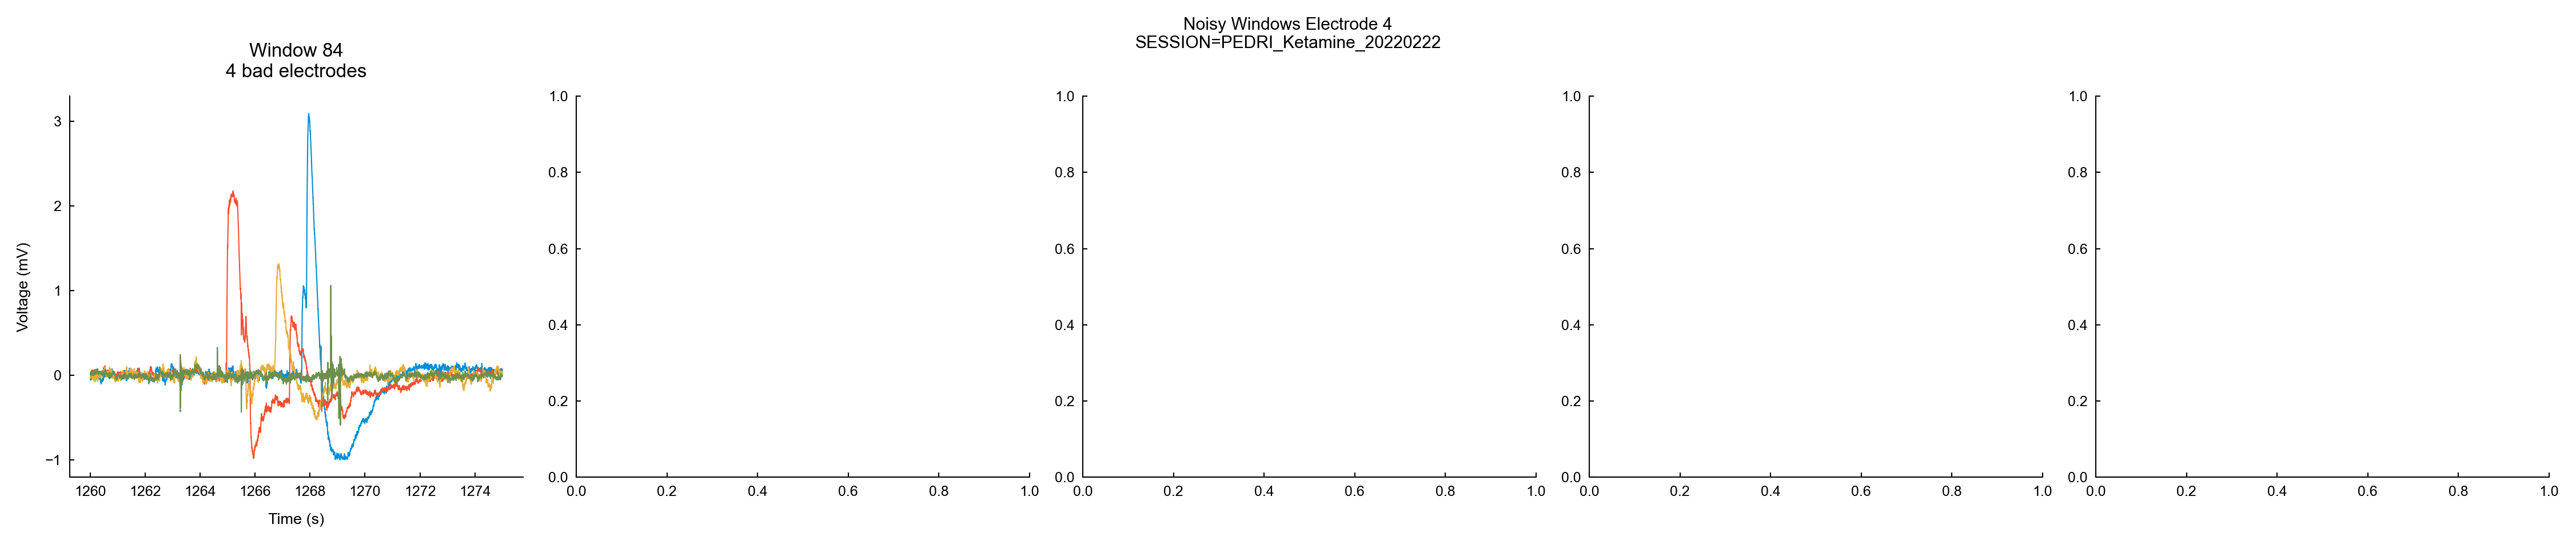

In [26]:

ncols = 5
nrows = int(np.ceil(len(bad_electrode_df) / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3), sharex=False, sharey=False)

num_electrodes_to_plot = 5

window_num = 0
for i, row in tqdm(bad_electrode_df.iterrows(), total=len(bad_electrode_df)):
    ax = axs.flat[window_num]
    window_start = row.window_start
    window_end = row.window_end
    noisy_window_data = lfp[int(window_start/dt):int((window_end)/dt)]
    electrodes_to_plot = row.max_vals.argsort()[::-1][:np.min([len(row.bad_electrodes), num_electrodes_to_plot])]
    electrodes_to_plot = (np.concat(([electrode_num], [elec for elec in electrodes_to_plot if elec != electrode_num]))).astype(int)

    ax.plot(np.arange(window_start, window_end, dt), noisy_window_data[:, electrodes_to_plot])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (mV)')
    ax.set_title(f'Window {i}\n{row.num_bad_electrodes} bad electrodes')

    window_num += 1
plt.tight_layout()
plt.suptitle(f'Noisy Windows Electrode {electrode_num}\nSESSION={session}', y=1.02)
plt.show()

In [27]:
electrode_num

4

In [28]:
time_vals = np.arange(0, T*dt, dt)

In [29]:
noisy_times = np.array([False]*len(time_vals))
for i,row in noisy_windows.iterrows():
    noisy_times[(time_vals >= row.window_start) & (time_vals < row.window_end)] = True

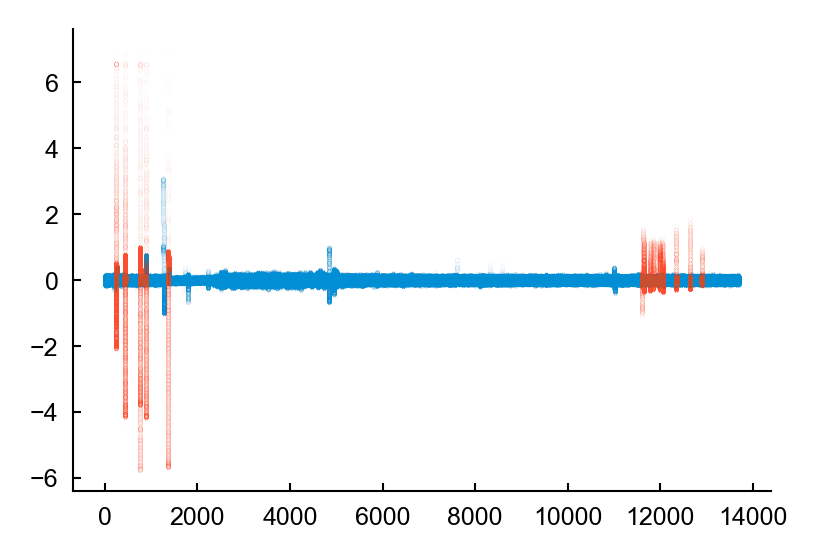

In [30]:
plt.scatter(time_vals[~noisy_times], lfp[~noisy_times][:, electrode_num])
plt.scatter(time_vals[noisy_times], lfp[noisy_times][:, electrode_num])
plt.show()

In [31]:
bad_electrode_df

,window_start,window_end,max_vals,bad_electrodes,num_bad_electrodes
84,1260.0,1275.0,"[0.42343396500963765, 0.4607065732720574, 0.47...","[4, 7, 43, 47]",4


In [32]:
row = bad_electrode_df.iloc[0]

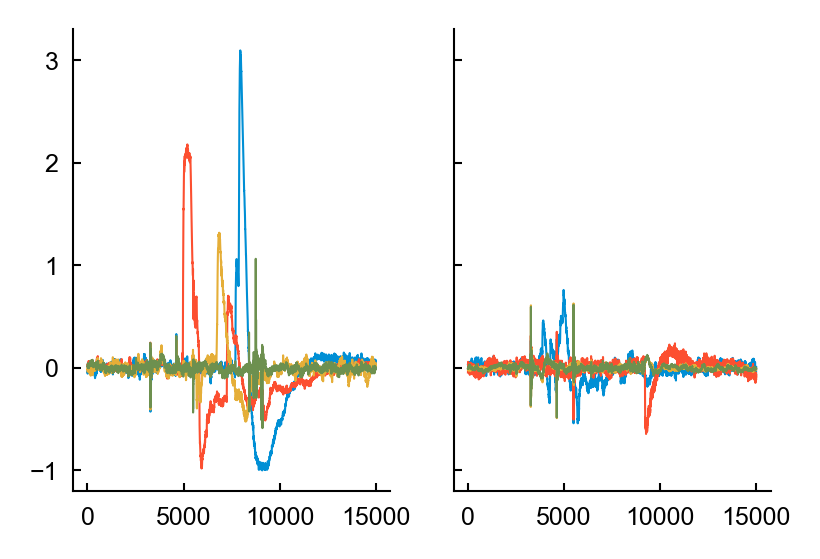

In [34]:
fig, axs = plt.subplots(1, 2, sharey=True)
window_data = lfp[int(row.window_start/dt):int((row.window_end)/dt)]

bad_electrode_inds = np.argsort(row.max_vals)[::-1][:row.num_bad_electrodes]
good_electrode_inds = np.argsort(row.max_vals)[::-1][row.num_bad_electrodes:]

ax = axs[0]
ax.plot(window_data[:, bad_electrode_inds])

ax = axs[1]
ax.plot(window_data[:, good_electrode_inds[:4]])

plt.show()